# Libraries

In [1]:
import pandas as pd
import gzip
import simplejson as json
from sklearn.utils import resample
import gc
import os
import re
import langdetect
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense , Input , LSTM , Embedding, Dropout , Activation, GRU, Flatten
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Convolution1D, Dropout
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers
from keras.constraints import maxnorm
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt
from matplotlib.pyplot import pie, axis, show
import numpy as np
import string
import collections
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, confusion_matrix

os.chdir("/Users/aontiveros/Others/CECS590")

Using TensorFlow backend.


# Functions

In [2]:
def csv2df(fname, sep='\t', na_values=np.nan):
    data = pd.read_csv(fname, sep=sep, na_values=na_values)
    return data

# For cleaning the text
stop_words = set(stopwords.words("english")) 
lemmatizer = WordNetLemmatizer()

def remove_punctuation(from_text):
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in from_text]
    return stripped

def remove_digits(list): 
    pattern = '[0-9]'
    list = [re.sub(pattern, '', i) for i in list]
    return list

def clean_text(text):
    text = re.sub(r'[^\w\s]','',text, re.UNICODE)
    text = text.lower()
    text = [lemmatizer.lemmatize(token) for token in text.split(" ")]
    text = remove_punctuation(text)
    text = [lemmatizer.lemmatize(token, "v") for token in text]
    text = [word for word in text if not word in stop_words]
    text = remove_digits(text)
    text = " ".join(text)
    return text

# Preprocessing

In [3]:
# Uploading file with reviws only in English
df = csv2df('kindle_store_english')
df.head()

,Unnamed: 0,overall,reviewText,languages,counting
0,562081,1,"As a freelancer, I have used Fiverr many times...",English,1
1,731922,1,love love this serie,English,1
2,309008,1,saying that I loved reading this story about a...,English,1
3,1145290,1,Couldn't stop reading! Loved it! Can't wait to...,English,1
4,692769,1,The best one way better then the second book.,English,1


In [4]:
# Droping languages column
df = df.drop(columns=['languages', 'counting', 'Unnamed: 0'])

# Renaming columns
df.rename(columns = {'overall':'polarity', 'reviewText':'review'}, inplace = True) 
df.head()

,polarity,review
0,1,"As a freelancer, I have used Fiverr many times..."
1,1,love love this serie
2,1,saying that I loved reading this story about a...
3,1,Couldn't stop reading! Loved it! Can't wait to...
4,1,The best one way better then the second book.


In [5]:
y = df['polarity']
X = df['review']

# Randomly spliting the DF. Training 90% and testing 10%. Stratified on y.
X_train_pre, X_test, y_train_pre, y_test = train_test_split(X, y, test_size=0.1, random_state=1, stratify=y)
# Randomly spliting the train_pre. Training 90% and validation 10%. Stratified on y. 
X_train, X_validation, y_train, y_validation = train_test_split(X_train_pre, y_train_pre, test_size=0.1, 
                                                                random_state=1, stratify=y_train_pre)

# Sending them to a DF
X_train = pd.Series(X_train, name="review")
X_train = X_train.to_frame()
X_test = pd.Series(X_test, name="review")
X_test = X_test.to_frame()
X_validation = pd.Series(X_validation, name="review")
X_validation = X_validation.to_frame()
y_validation = y_validation.to_frame()

del X, y, df, X_train_pre, y_train_pre
gc.collect()

29

In [6]:
# Cleaning the text separately
X_train['Processed_Reviews'] = X_train.review.apply(lambda x: clean_text(x))
X_test['Processed_Reviews'] = X_test.review.apply(lambda x: clean_text(x))
X_validation['Processed_Reviews'] = X_validation.review.apply(lambda x: clean_text(x))

# Removing word 'book'
remove_words = ['book']
removing = r'\b(?:{})\b'.format('|'.join(remove_words))
X_train['Processed_Reviews'] = X_train['Processed_Reviews'].str.replace(removing, '')
X_test['Processed_Reviews'] = X_test['Processed_Reviews'].str.replace(removing, '')
X_validation['Processed_Reviews'] = X_validation['Processed_Reviews'].str.replace(removing, '')

In [10]:
X_train['polarity'] = y_train

df_positive = X_train[X_train.polarity==1]
df_negative = X_train[X_train.polarity==0]

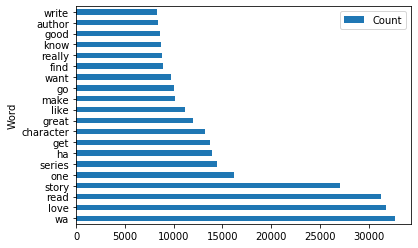

In [11]:
# Most frequent words from positive reviews
wordcount = {}

for val in df_positive.Processed_Reviews: 
    val = str(val)
    tokens = val.split() 
    for words in tokens:   
        if words not in wordcount:
            wordcount[words] = 1
        else:
            wordcount[words] += 1

word_counter = collections.Counter(wordcount)
lst = word_counter.most_common(20)
dfp = pd.DataFrame(lst, columns = ['Word', 'Count'])
dfp.plot.barh(x='Word',y='Count')

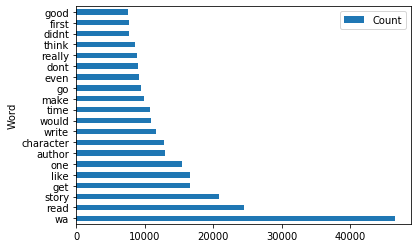

In [12]:
# Most frequent words from negative reviews
wordcount2 = {}

for val2 in df_negative.Processed_Reviews: 
    val2 = str(val2)
    tokens2 = val2.split() 
    for words2 in tokens2:   
        if words2 not in wordcount2:
            wordcount2[words2] = 1
        else:
            wordcount2[words2] += 1

word_counter2 = collections.Counter(wordcount2)
lst2 = word_counter2.most_common(20)
dfn = pd.DataFrame(lst2, columns = ['Word', 'Count'])
dfn.plot.barh(x='Word',y='Count')

In [13]:
print('Average lenght of reviews for training df: ', 
      X_test.Processed_Reviews.apply(lambda x: len(x.split(" "))).mean())
print('Average lenght of reviews for testing df: ', 
      X_train.Processed_Reviews.apply(lambda x: len(x.split(" "))).mean())
print('Average lenght of reviews for validation df: ', 
      X_validation.Processed_Reviews.apply(lambda x: len(x.split(" "))).mean())

maxlen = int(X_test.Processed_Reviews.apply(lambda x: len(x.split(" "))).mean()) # Taken from mean lenght of reviews
print('Max lenght for sentences: ', maxlen) 

Average lenght of reviews for training df:  45.939585792467
Average lenght of reviews for testing df:  46.17170753679636
Average lenght of reviews for validation df:  47.2078216287111
Max lenght for sentences:  45


In [14]:
print('Number of samples in X_train df: ', X_train['Processed_Reviews'].count())
print('Number of samples in X_test df: ', X_test['Processed_Reviews'].count())
print('Number of samples in X_validation df: ', X_validation['Processed_Reviews'].count())

# Setting y for all the datasets
X_train['polarity'] = y_train
X_test['polarity'] = y_test
X_validation['polarity'] = y_validation

Number of samples in X_train df:  75483
Number of samples in X_test df:  9319
Number of samples in X_validation df:  8387


In [15]:
max_features = 2000 # Max number of features in sample / max number of words
# Tokenizing 
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_train['Processed_Reviews'])
list_tokenized_train = tokenizer.texts_to_sequences(X_train['Processed_Reviews'])
list_tokenized_validation = tokenizer.texts_to_sequences(X_validation['Processed_Reviews'])
list_tokenized_test = tokenizer.texts_to_sequences(X_test['Processed_Reviews'])

X_tr = pad_sequences(list_tokenized_train, maxlen=maxlen)
y_tr = X_train['polarity']
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)
y_te = X_test['polarity']
X_va = pad_sequences(list_tokenized_validation, maxlen=maxlen)
y_va = X_validation['polarity']

In [16]:
# Function to create model, required for KerasClassifier
embed_size = maxlen #Dimension of the dense embedding. Set as max lengh of a sentence/review.
hidden_nodes = [8, 18, 32] # For the LSTM, to try in the for loop. 
# define the grid search parameters
dropout_rate = [0.02, 0.05]
n_epochs = [3, 5]
n_batch = [8, 16] #4,8,16,32,64,128,256 (powers of 2) can be tried, this dependens on CPU/GPU memory capacity

for hn in hidden_nodes:
    def create_model(dropout_rate=0.0, no_nodes=0):
        # create model
        model = Sequential()
        model.add(Embedding(max_features, embed_size))
        model.add(Bidirectional(LSTM(hn, return_sequences = True)))
        model.add(GlobalMaxPool1D())
        model.add(Dropout(dropout_rate))
        model.add(Dense(1, activation="sigmoid"))
        # Compile model
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        return model
    # create model
    model = KerasClassifier(build_fn=create_model)
    param_grid = dict(dropout_rate=dropout_rate, epochs=n_epochs, batch_size=n_batch)
    grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
    grid_result = grid.fit(X_tr, y_tr)
    print('Number of hidden nodes used: ', hn)
    print('The best score obtained with GridSearchCV, was: ', grid_result.best_score_)
    print('The best parameters obtained with GridSearchCV, were: ', grid_result.best_params_)   

Train on 75483 samples
Epoch 1/5
75483/75483 [==============================] - 158s 2ms/sample - loss: 0.2237 - accuracy: 0.9120
Epoch 2/5
75483/75483 [==============================] - 154s 2ms/sample - loss: 0.1711 - accuracy: 0.9347
Epoch 3/5
75483/75483 [==============================] - 154s 2ms/sample - loss: 0.1520 - accuracy: 0.9425
Epoch 4/5
75483/75483 [==============================] - 154s 2ms/sample - loss: 0.1364 - accuracy: 0.9496
Epoch 5/5
75483/75483 [==============================] - 154s 2ms/sample - loss: 0.1240 - accuracy: 0.9544
Number of hidden nodes used:  8
The best score obtained with GridSearchCV, was:  0.9295867880185446
The best parameters obtained with GridSearchCV, were:  {'batch_size': 8, 'dropout_rate': 0.02, 'epochs': 5}
Train on 75483 samples
Epoch 1/5
75483/75483 [==============================] - 171s 2ms/sample - loss: 0.2169 - accuracy: 0.9134
Epoch 2/5
75483/75483 [==============================] - 170s 2ms/sample - loss: 0.1654 - accuracy: 0.93

In [17]:
# Best parameters
bs = 8# batch_size
e = 3# epochs
hn = 32# hidden nodes
dr = 0.02# dropout rate

model_final = Sequential()
model_final.add(Embedding(max_features, embed_size))
model_final.add(Bidirectional(LSTM (hn, return_sequences = True)))
model_final.add(GlobalMaxPool1D())
model_final.add(Dropout(dr))
model_final.add(Dense(1, activation="sigmoid"))
model_final.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [18]:
# Fiting the model with training and validating
history = model_final.fit(X_tr, y_tr, epochs=e, batch_size=bs, validation_data=(X_va, y_va))

Train on 75483 samples, validate on 8387 samples
Epoch 1/3
75483/75483 [==============================] - 174s 2ms/sample - loss: 0.2124 - accuracy: 0.9171 - val_loss: 0.1834 - val_accuracy: 0.9282
Epoch 2/3
75483/75483 [==============================] - 184s 2ms/sample - loss: 0.1651 - accuracy: 0.9372 - val_loss: 0.1706 - val_accuracy: 0.9319
Epoch 3/3
75483/75483 [==============================] - 179s 2ms/sample - loss: 0.1445 - accuracy: 0.9463 - val_loss: 0.1666 - val_accuracy: 0.9339


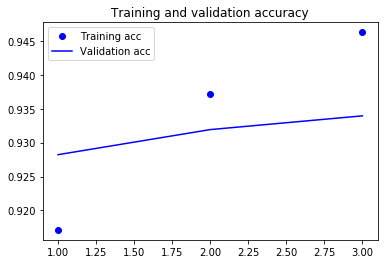

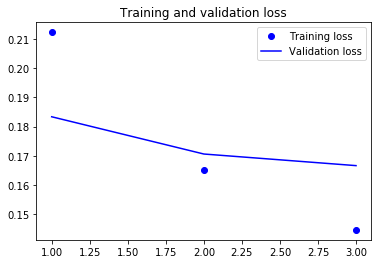

In [19]:
# Plots of results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [20]:
# Tokenizing test dataset
#list_tokenized_test = tokenizer.texts_to_sequences(X_test['Processed_Reviews'])

#maxlen = 50 # Taken from mean lenght of reviews. Rounded. 
#X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

prediction = model_final.predict(X_te)
y_pred = (prediction > 0.5)

print('F1-score: {0}'.format(f1_score(y_pred, y_te)))
print('Confusion matrix:')
confusion_matrix(y_pred, y_te)

F1-score: 0.940187313750532
Confusion matrix:


array([[4340,  265],
       [ 297, 4417]])

In [21]:
target_names = ['class 0', 'class 1']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.94      0.94      0.94      4637
     class 1       0.94      0.94      0.94      4682

    accuracy                           0.94      9319
   macro avg       0.94      0.94      0.94      9319
weighted avg       0.94      0.94      0.94      9319



In [22]:
y_te.value_counts()

1    4682
0    4637
Name: polarity, dtype: int64